In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
dataset = pd.read_csv('Second Iteration Data/dataset.csv')

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16792 entries, 0 to 16791
Data columns (total 22 columns):
tag_header                 16792 non-null object
tag_para                   16792 non-null object
tag_formatting             16792 non-null object
word_count                 16792 non-null int64
interacting_span_tag       16792 non-null object
relative_x_coord           16792 non-null float64
relative_y_coord           16792 non-null float64
relative_listings          16792 non-null float64
relative_hyperlinks        16792 non-null float64
tag_img                    16792 non-null object
src_img_interaction        16792 non-null object
red_flag_class             16792 non-null object
tag_table                  16792 non-null object
tag_sup                    16792 non-null object
tag_sup_child              16792 non-null object
tag_tab_elem               16792 non-null object
red_flag_id                16792 non-null object
relative_table_elements    16792 non-null float64
heigh

## Selecting all the observations with non empty labels

In [10]:
data = dataset.loc[~dataset['label'].isna()]

In [11]:
print(data.shape)
print(dataset.shape)

(2561, 22)
(16792, 22)


- We can see that there out of the ~16.5k values we have recorded, only ~2.5k values are of importance

In [12]:
data['label'].value_counts()

1.0    1619
0.0     942
Name: label, dtype: int64

- So we have 942 occurences with unnecessary label and 1619 observations with necessary label.

- 36.7% of the data in the sample are labelled unnecessary and 63.3% are labelled necessary. 

### Let us look at the distribution of word_count for different labels.

In [13]:
word_count_necessary = data.loc[data['label'] == 1.0, 'word_count'].values
word_count_unnecessary = data.loc[data['label'] == 0.0, 'word_count'].values

# word_count_unnecessary = [num + 0.1 for num in word_count_unnecessary]
# word_count_unnecessary = np.log(word_count_unnecessary)

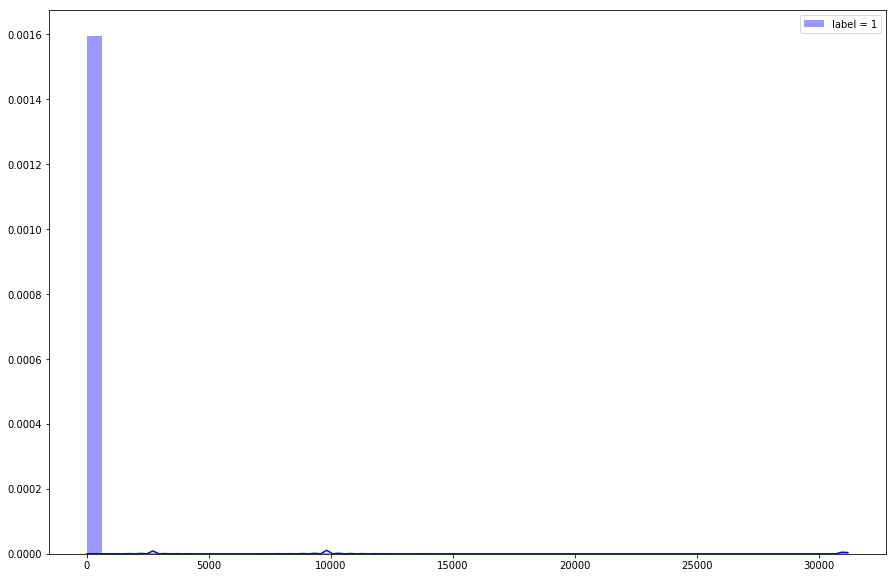

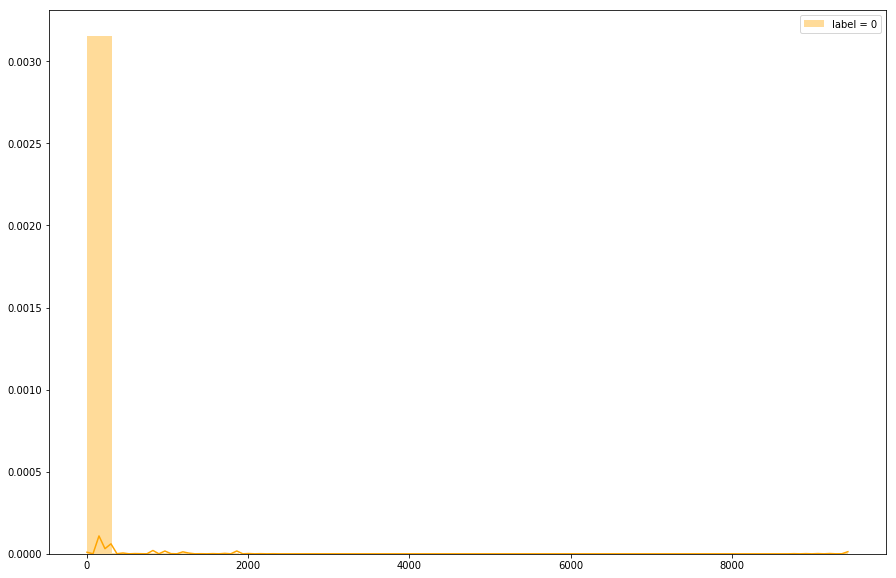

Min and Max of word_count in necessary tags: 
1
31181
Min and Max of word_count in unnecessary tags: 
0
9442


In [23]:
plt.figure(figsize = (15,10))

sns.distplot(word_count_necessary, label = 'label = 1', color = 'blue')
plt.legend()
plt.show()

plt.figure(figsize = (15,10))
sns.distplot(word_count_unnecessary, label = 'label = 0', color = 'orange')
plt.legend()
plt.show()

print('Min and Max of word_count in necessary tags: ')
print(min(word_count_necessary))
print(max(word_count_necessary))

print('Min and Max of word_count in unnecessary tags: ')
print(min(word_count_unnecessary))
print(max(word_count_unnecessary))

- Observation 1 - There are a lot of necessary tags with very low word_count values. Hunch - a tags, header tags etc. Let's examine which tags generate such data, in order to develop some remedy.
- Observation 2 - There are a few unnecessary tags with very high word_count values. Hunch - unncessary elements at the bottom of the page, such as - References, See Also, etc. Could multiplying word_count by (1 - relative_y_coord solve this)?

In [36]:
necessary_tags = data[(data['label'] == 1.0)]
necessary_tags_low_count = necessary_tags.loc[(data['word_count']) < 10]

print(necessary_tags_low_count.name.value_counts())

a       1040
span     108
i         67
h3        48
h4        37
h2        23
dt        11
b          8
p          5
li         3
h1         3
div        1
cite       1
Name: name, dtype: int64


- As expected there are a lot of hyperlinks, span(with headers) tags, header tags, formatting tags (b and i) with very low word_count. The remedy for them could be to have some multiplier, which works as :
      
       If the tag is header(or the others written above), multiply the word_count by 10, 
       else multiply by 1.
       For header and span tags within headers, this multiplication can cause problems 
       - it might generate outlier values for headers at the lower part of the page. 
       Hence there has to be a multiplier correlated with y coordinate too.
       
- Check which p tags have such low values of word_count for caution. Don't have a multiplier for them as of yet.
       
- For other tags such as dt, li, div and cite, examine further before remedying them. However, they are very low in number(a total of just 16), so they can be kept as it is.

In [37]:
unnecessary_tags = data[(data['label'] == 0.0)]
unnecessary_tags_low_count = unnecessary_tags.loc[(data['word_count']) > 10]

print(unnecessary_tags_low_count.name.value_counts())

div      60
ul        4
table     4
style     2
span      1
Name: name, dtype: int64


- divs with high word_count refer to the divs with note(hatnote), divs with images(may be), divs within References/See Also type sections. Check them thoroughly before proceeding with some multiplier value.

- Same goes for ul tags.

- For table tag, we can have a multiplier which works in the opposite sense as above.

        If tag_table is 'YES' multiply bu 0.1, else multiply by 1.
        
- Check which style and span tags have high word_count, later on. Leaving them at this point should not make much of a problem.

In [42]:
unnecessary_tags_low_count_div = unnecessary_tags_low_count[unnecessary_tags_low_count['name'] == 'div']

# Checking for divs at upper locations
unnecessary_tags_low_count_div_up = unnecessary_tags_low_count_div[unnecessary_tags_low_count_div['relative_y_coord'] < 0.5]
print('For divs at upper locations')
print(unnecessary_tags_low_count_div_up.attrs.value_counts)
print('------------------------------')
# Checking for divs at lower locations
unnecessary_tags_low_count_div_low = unnecessary_tags_low_count_div[unnecessary_tags_low_count_div['relative_y_coord'] > 0.5]
print('For divs at lower locations')
print(unnecessary_tags_low_count_div_low.attrs.value_counts)

For divs at upper locations
<bound method IndexOpsMixin.value_counts of 1067     ['note', ['hatnote', 'navigation-not-searchabl...
1069     [['shortdescription', 'nomobile', 'noexcerpt',...
1391                                      ['toc', ['toc']]
1604                                 [['thumb', 'tright']]
2112                                 [['thumb', 'tright']]
4359                                        ['contentSub']
4374     ['note', ['hatnote', 'navigation-not-searchabl...
4599                                      [['toclimit-3']]
4934     ['note', ['hatnote', 'navigation-not-searchabl...
4937                                 [['thumb', 'tright']]
5215                                 [['thumb', 'tright']]
5237                                 [['thumb', 'tright']]
5302                                 [['thumb', 'tright']]
5384                                 [['thumb', 'tright']]
5451                                 [['thumb', 'tright']]
5490                                 [['thu

- As expected, at upper locations, this anomaly is due to Table of Contents section, hatnotes, and at lower locations it is mostly due to sections in references.
        
        This can be remedied by mulitplying with 0.1 if the tag is div and red_flag_class 
        is 'YES', else multiply by 1.

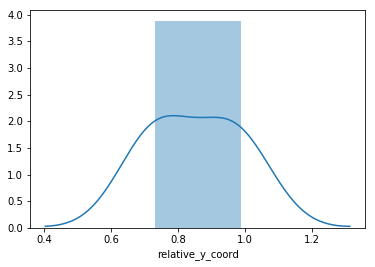

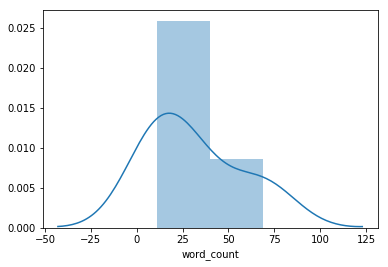

In [46]:
unnecessary_tags_low_count_ul = unnecessary_tags_low_count[unnecessary_tags_low_count['name'] == 'ul']

sns.distplot(unnecessary_tags_low_count_ul['relative_y_coord'])
plt.show()
sns.distplot(unnecessary_tags_low_count_ul['word_count'])

- The word_count for ul tags is considerably high. So remedying this can't be ignored. We can do this as - 
        
        We can multiply 0.1 if the relative_y_coord is greater than a certain value.
        
- How do we find this value? Let's look at the values of relative_y_coord where tag_header is 'YES' but label is '0' in the data.

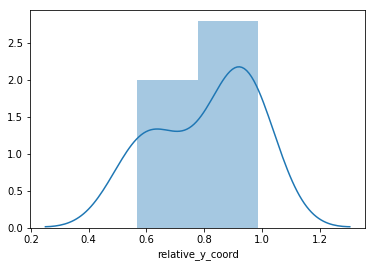

In [48]:
unnecessary_headers = data[(data['tag_header'] == 'YES') & (data['label'] == 0)]

sns.distplot(unnecessary_headers['relative_y_coord'])
plt.show()

necessary_tags = data[data['label'] == 1.0]

- We can have a threshold value of ~0.65 (tune it between 0.6 and 0.7 against word_count distribution).

## Takeaways

- For 'YES' values of tag_header, interacting_span_tag, tag_formatting multiply the word_count by 10, else by 1.

- For div tags, if red_flag_class is 'YES', multiply by 0.1, else by 1.

- Multiply the word_count 